In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
folder_list = []
train_dir = Path('train')

for folder in train_dir.iterdir():
    folder_list.append(folder)
folder_list


[WindowsPath('train/00001'),
 WindowsPath('train/00002'),
 WindowsPath('train/00003'),
 WindowsPath('train/00004'),
 WindowsPath('train/00005'),
 WindowsPath('train/00006'),
 WindowsPath('train/00007'),
 WindowsPath('train/00008'),
 WindowsPath('train/00009'),
 WindowsPath('train/00010')]

In [3]:
training_dir = []
targets_dir = []

for folder in folder_list:
    if folder.is_dir():
        training_dir.append(folder/'train_stage1.csv')
        targets_dir.append(folder/'targets.csv')
training_dir

[WindowsPath('train/00001/train_stage1.csv'),
 WindowsPath('train/00002/train_stage1.csv'),
 WindowsPath('train/00003/train_stage1.csv'),
 WindowsPath('train/00004/train_stage1.csv'),
 WindowsPath('train/00005/train_stage1.csv'),
 WindowsPath('train/00006/train_stage1.csv'),
 WindowsPath('train/00007/train_stage1.csv'),
 WindowsPath('train/00008/train_stage1.csv'),
 WindowsPath('train/00009/train_stage1.csv'),
 WindowsPath('train/00010/train_stage1.csv')]

Random Forest

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import brier_score_loss

def set_label(row):
    probabilities = row[2:]
    max_prob_index = probabilities.idxmax()
    return max_prob_index

train_dataframes = [pd.read_csv(f) for f in training_dir]

kf = KFold(n_splits=5)

scores = []

counts = 0

model_importance = []


for train_indices, val_indices in kf.split(train_dataframes):
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

    X_train = pd.concat([train_dataframes[i].drop(['location', 'label'], axis=1) for i in train_indices], ignore_index=True)
    X_train['room'] = X_train['room'].replace({'living_room':1, 'hallway':2, 'kitchen':3})
    y_train = pd.concat([train_dataframes[i]['label'] for i in train_indices], ignore_index=True)
    
    X_val = pd.concat([train_dataframes[i].drop(['location', 'label'], axis=1) for i in val_indices], ignore_index=True)
    X_val['room'] = X_val['room'].replace({'living_room':1, 'hallway':2, 'kitchen':3})
    y_val = pd.concat([train_dataframes[i]['label'] for i in val_indices], ignore_index=True)


    rf_model.fit(X_train, y_train)

    model_importance.append(rf_model.feature_importances_)

    counts += 1
    y_preds = rf_model.predict(X_val)

    acc = accuracy_score(y_val, y_preds)
    scores.append(acc)
    print(f'Fit {counts}: Accuracy = {acc}')



print(f'Accuracy mean: {np.mean(scores)}')



Fit 1: Accuracy = 0.5455349248452697
Fit 2: Accuracy = 0.5240746806419915
Fit 3: Accuracy = 0.5962732919254659
Fit 4: Accuracy = 0.5592686002522068
Fit 5: Accuracy = 0.5103964513446078
Accuracy mean: 0.5471095898019083


In [5]:
import matplotlib.pyplot as plt
features = train_dataframes[1].drop(['label', 'location'], axis=1).columns
importance_df = pd.DataFrame()

importance_df['features'] = features

fit_counts = 1
for prob in model_importance:
    new_col_name = 'Fit ' + str(fit_counts)
    importance_df[new_col_name] = prob
    fit_counts += 1

importance_df['mean'] = importance_df.drop('features', axis=1).mean(axis=1)
importance_df = importance_df.sort_values(by='mean')
importance_df


,features,Fit 1,Fit 2,Fit 3,Fit 4,Fit 5,mean
22,3d_shape_mean_depth,0.000443,0.000604,0.000840,0.000299,0.000492,0.000536
25,room,0.002948,0.003620,0.003140,0.003308,0.003839,0.003371
23,3d_shape_std_width,0.009920,0.009616,0.009203,0.009228,0.010080,0.009609
18,2d_shape_std_width,0.010037,0.010226,0.009457,0.008973,0.010805,0.009900
19,2d_shape_std_height,0.010326,0.009725,0.010004,0.009777,0.010784,0.010123
24,3d_shape_std_height,0.010525,0.010187,0.009738,0.009863,0.011192,0.010301
14,3d_movement_std_y,0.012765,0.012736,0.011911,0.013238,0.012613,0.012652
13,3d_movement_std_x,0.013550,0.013617,0.012889,0.012601,0.013206,0.013173
8,2d_movement_std_x,0.014130,0.014212,0.013559,0.011934,0.013708,0.013508
9,2d_movement_std_y,0.015687,0.014857,0.014785,0.014403,0.014864,0.014919


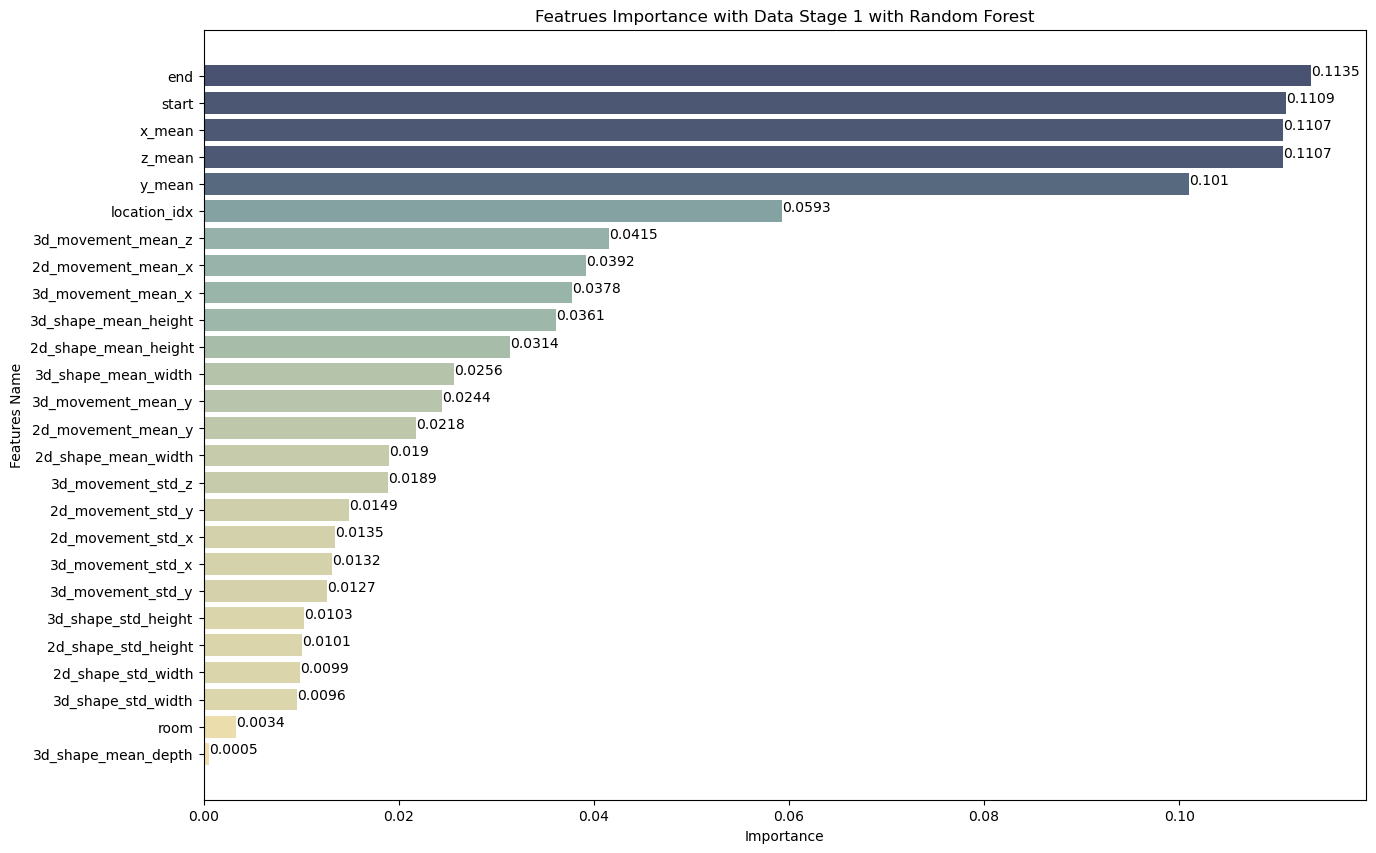

In [39]:
from matplotlib.colors import LinearSegmentedColormap

colors = ['#f1e0ac', '#98b4aa', '#74959a', '#495371']
selfcmap = LinearSegmentedColormap.from_list('selfcmap',colors)

norm = plt.Normalize(min(importance_df['mean']), max(importance_df['mean']))
bar_colors = [selfcmap(norm(value)) for value in importance_df['mean']]

plt.figure(figsize=(15, 10))
plt.barh(importance_df['features'], importance_df['mean'], color=bar_colors)
plt.ylabel('Features Name')
plt.xlabel('Importance')
plt.title('Featrues Importance with Data Stage 1 with Random Forest')

for index, value in enumerate(importance_df['mean']):
    plt.text(value, index, str(round(value, ndigits=4)))

plt.show()

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import ast
from sklearn.metrics import brier_score_loss

datasets = []
for i in range(1, 11):
    df = pd.read_csv(f'train/{i:05d}/train_stage2.csv')
    df['target_vector'] = df['target_vector'].apply(ast.literal_eval) 
    
    # target_vector max to 1 other to 0
    def set_max_to_one(target_list):
        max_value = max(target_list)
        return [1 if value == max_value else 0 for value in target_list]
    
    target_df = pd.DataFrame(df['target_vector'].apply(set_max_to_one).tolist(), index=df.index)
    features_df = df.drop(columns=['target_vector'])
    datasets.append((features_df, target_df))
kf = KFold(n_splits=5, shuffle=True, random_state=42)


brier_scores1 = []

model_importance1 = []


for train_index, test_index in kf.split(datasets):

    X_train = pd.concat([datasets[i][0] for i in train_index], ignore_index=True)
    y_train = pd.concat([datasets[i][1] for i in train_index], ignore_index=True)
    

    X_test = pd.concat([datasets[i][0] for i in test_index], ignore_index=True)
    y_test = pd.concat([datasets[i][1] for i in test_index], ignore_index=True)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    

    model = MultiOutputClassifier(rf)
    model.fit(X_train, y_train)

    model_importance1.append(estimator.feature_importances_ for estimator in model.estimators_)
    

    y_prob = model.predict_proba(X_test)
    brier_score = np.mean([brier_score_loss(y_test.iloc[:, c], y_prob[c][:, 1], pos_label=1) for c in range(y_test.shape[1])])
    print(f'brier_score: {brier_score}')
    brier_scores1.append(brier_score)


print(f'Average score across all folds: {np.mean(brier_scores1)}')


brier_score: 0.03528205568378534


KeyboardInterrupt: 

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
import ast
from sklearn.metrics import brier_score_loss

datasets = []
for i in range(1, 11):
    df = pd.read_csv(f'train/{i:05d}/train_stage3.csv')
    df['target_vector'] = df['target_vector'].apply(ast.literal_eval) 
    
    # target_vector max to 1 other to 0
    def set_max_to_one(target_list):
        max_value = max(target_list)
        return [1 if value == max_value else 0 for value in target_list]
    
    target_df = pd.DataFrame(df['target_vector'].apply(set_max_to_one).tolist(), index=df.index)
    features_df = df.drop(columns=['target_vector'])
    datasets.append((features_df, target_df))
kf = KFold(n_splits=5, shuffle=True, random_state=42)


brier_scores2 = []

model_importance2 = []

for train_index, test_index in kf.split(datasets):

    X_train = pd.concat([datasets[i][0] for i in train_index], ignore_index=True)
    y_train = pd.concat([datasets[i][1] for i in train_index], ignore_index=True)
    

    X_test = pd.concat([datasets[i][0] for i in test_index], ignore_index=True)
    y_test = pd.concat([datasets[i][1] for i in test_index], ignore_index=True)

    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    

    model = MultiOutputClassifier(rf)
    model.fit(X_train, y_train)
    
    model_importance2.append(estimator.feature_importances_ for estimator in model.estimators_)

    y_prob = model.predict_proba(X_test)
    brier_score = np.mean([brier_score_loss(y_test.iloc[:, c], y_prob[c][:, 1], pos_label=1) for c in range(y_test.shape[1])])
    print(f'brier_score: {brier_score}')
    brier_scores2.append(brier_score)


print(f'Average score across all folds: {np.mean(brier_scores2)}')




brier_score: 0.03352585545297172
brier_score: 0.030978308402291533
brier_score: 0.02935145303173108
brier_score: 0.028532182818709877
brier_score: 0.026258372781065086
Average score across all folds: 0.029729234497353856


In [25]:
importance_df2 = pd.DataFrame()

features2 = pd.read_csv('train/00001/train_stage3.csv').drop('target_vector', axis=1).columns

importance_df2['features'] = features2

counter = 1
for generator in model_importance2:
    for value in generator:
        col_name = 'value' + str(counter)
        importance_df2[col_name] = value
        counter += 1

C:\Users\fragment\AppData\Local\Temp\ipykernel_4016\1033038582.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df2[col_name] = value


[<generator object <genexpr> at 0x000001B6A3F1C790>,
 <generator object <genexpr> at 0x000001B6A3F1E260>,
 <generator object <genexpr> at 0x000001B6A3F1F2A0>,
 <generator object <genexpr> at 0x000001B6A3F1E4D0>,
 <generator object <genexpr> at 0x000001B6A3F1F6B0>]

In [27]:
importance_df2

,features,value1,value2,value3,value4,value5,value6,value7,value8,value9,...,value91,value92,value93,value94,value95,value96,value97,value98,value99,value100
0,start,0.079061,0.051651,0.044672,0.021063,0.032247,0.033921,0.029703,0.034942,0.054791,...,0.032185,0.027060,0.022124,0.033285,0.034999,0.031527,0.022723,0.029935,0.024527,0.035040
1,end,0.079501,0.042863,0.052599,0.019996,0.031660,0.030879,0.030233,0.036519,0.067098,...,0.033614,0.030449,0.023739,0.035475,0.032354,0.028367,0.020479,0.027750,0.021990,0.033983
2,location_idx,0.047856,0.031187,0.007878,0.004065,0.016375,0.036340,0.008980,0.013799,0.023834,...,0.023445,0.009579,0.004310,0.004888,0.007105,0.007762,0.005233,0.009023,0.010070,0.011480
3,Kitchen_AP,0.071977,0.019010,0.009492,0.023116,0.021515,0.009551,0.008310,0.004915,0.044752,...,0.030113,0.011858,0.004158,0.005746,0.004519,0.006929,0.005620,0.005935,0.009915,0.016012
4,Lounge_AP,0.020304,0.034158,0.004019,0.022032,0.011254,0.005609,0.020559,0.021774,0.008464,...,0.017263,0.009845,0.021203,0.024306,0.020319,0.014058,0.016073,0.017895,0.009544,0.013221
5,Upstairs_AP,0.060782,0.038179,0.020204,0.012346,0.026499,0.026955,0.018375,0.027089,0.027049,...,0.032180,0.020392,0.017071,0.022830,0.021758,0.015043,0.022529,0.030840,0.018474,0.020180
6,Study_AP,0.017382,0.011511,0.003896,0.005193,0.008813,0.008400,0.014985,0.007564,0.012425,...,0.009173,0.007648,0.014328,0.008123,0.006235,0.013918,0.014932,0.010635,0.008235,0.008153
7,2d_movement_mean_x,0.003551,0.006750,0.005546,0.015210,0.018015,0.015246,0.009031,0.009493,0.094580,...,0.021129,0.012508,0.010115,0.008886,0.013398,0.014026,0.008189,0.011589,0.012167,0.011313
8,2d_movement_mean_y,0.005109,0.016002,0.005299,0.031653,0.011613,0.019905,0.028430,0.006709,0.025175,...,0.049719,0.013170,0.010490,0.009062,0.010338,0.015053,0.020109,0.009829,0.011547,0.009849
9,2d_movement_std_x,0.004332,0.009547,0.006983,0.013533,0.029706,0.005277,0.006163,0.004964,0.006786,...,0.011022,0.009427,0.006589,0.007153,0.010496,0.010524,0.007400,0.008574,0.007805,0.010371


In [31]:
importance_df2['mean'] = importance_df2.drop('features', axis=1).mean(axis=1)
importance_df2 = importance_df2.sort_values(by='mean')

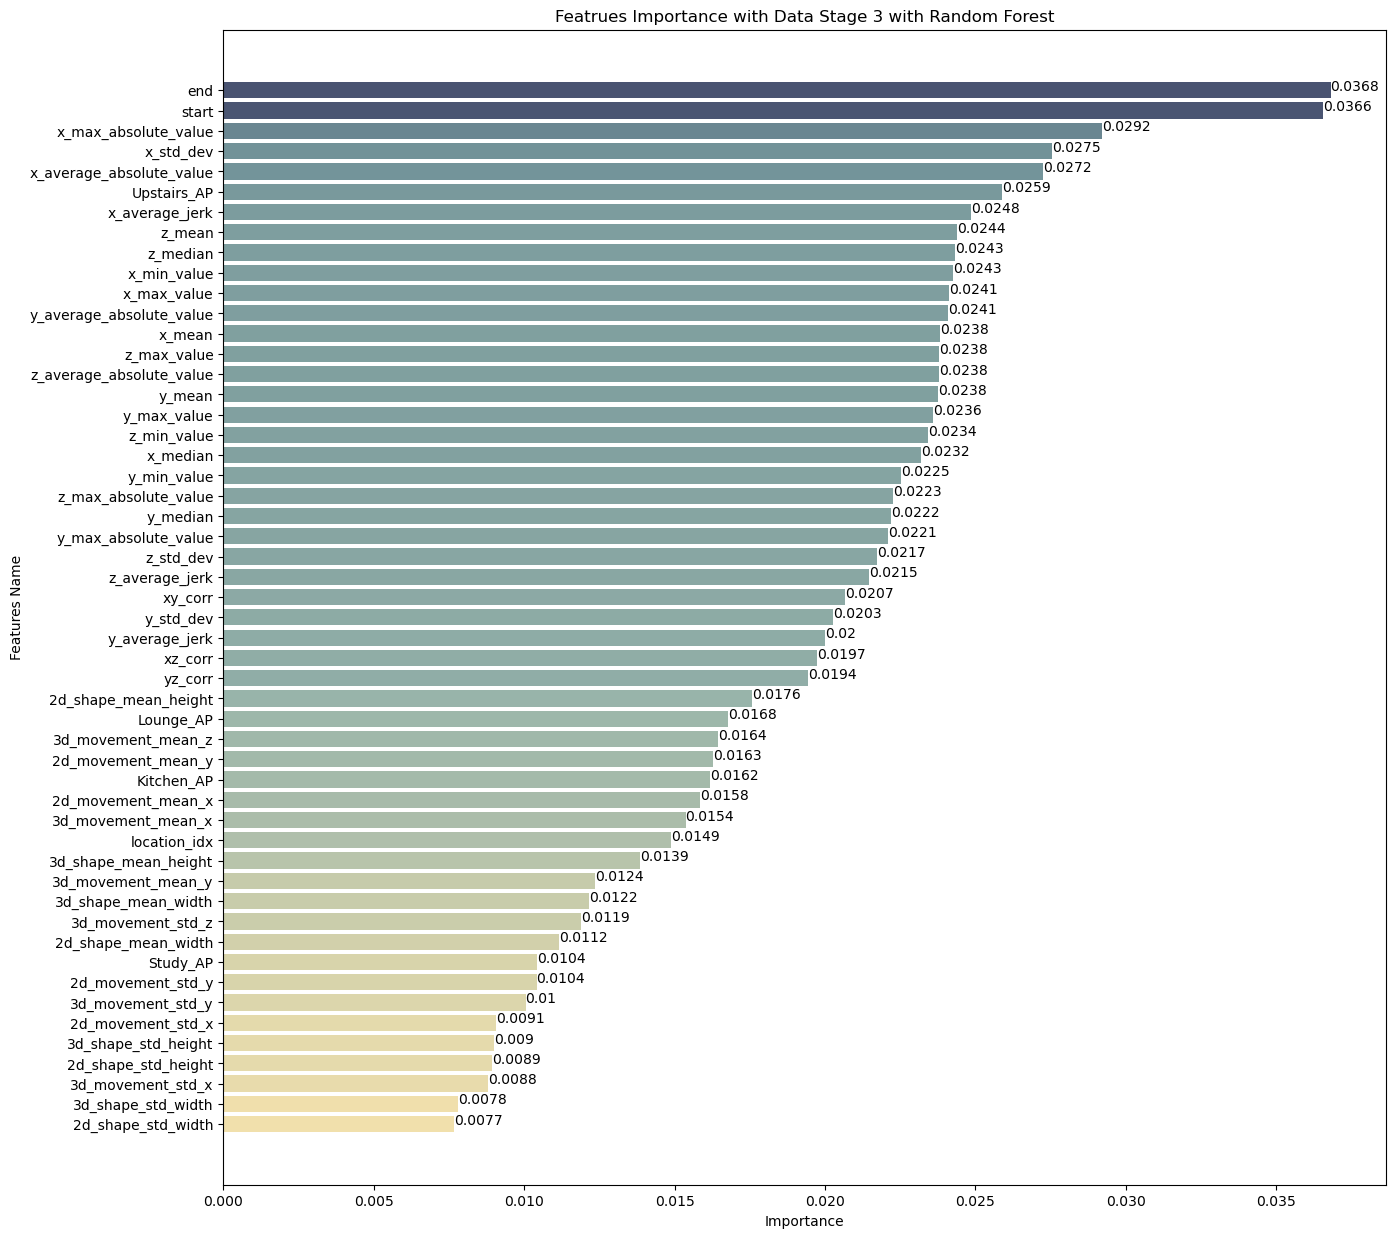

In [42]:
colors = ['#f1e0ac', '#98b4aa', '#74959a', '#495371']
selfcmap = LinearSegmentedColormap.from_list('selfcmap',colors)

norm = plt.Normalize(min(importance_df2['mean']), max(importance_df2['mean']))
bar_colors = [selfcmap(norm(value)) for value in importance_df2['mean']]

plt.figure(figsize=(15, 15))
plt.barh(importance_df2['features'], importance_df2['mean'], color=bar_colors)
plt.ylabel('Features Name')
plt.xlabel('Importance')
plt.title('Featrues Importance with Data Stage 3 with Random Forest')

for index, value in enumerate(importance_df2['mean']):
    plt.text(value, index, str(round(value, ndigits=4)))

plt.show()